In [1]:
import numpy as np
import numpy.linalg as LA
import scipy.sparse.linalg as spla
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import gmres
from scipy.sparse import diags
from scipy.sparse import identity
from scipy.linalg import sqrtm
from scipy.sparse.linalg import inv

import matplotlib.pyplot as plt

import ERFutils
import xarray as xr

In [2]:
from scipy import signal


train = '1pctCO2'
output_path = ERFutils.path_to_ERF_outputs
A = ERFutils.A

ERF_path = f'{output_path}ERF/ERF_{train}_all_ds.nc4'
ERF_ds = xr.open_dataset(ERF_path)
ERF_ds = ERFutils.concat_multirun(ERFutils.ds_to_dict(ERF_ds),'model').mean(dim = 'model')

ERF = ERF_ds.ERF
ERF_ds.close()

n = len(ERF_ds['year'])

tas_path = f'{output_path}tas/tas_CMIP_{train}_all_ds.nc4'
tas_ds = (xr.open_dataset(tas_path)).mean(dim = 'model')
tas_glob_ds = (tas_ds.weighted(A).mean(dim = ['lat','lon'])).rename({'s': 'year'})
tas_glob_ds = tas_glob_ds.sel(year = slice(ERF_ds['year'].min(), ERF_ds['year'].max()))

tas_glob = tas_glob_ds.tas
tas_ds.close()

In [3]:
corr = signal.correlate(tas_glob, ERF)
lags = signal.correlation_lags(len(ERF), len(tas_glob))
corr /= np.max(corr)

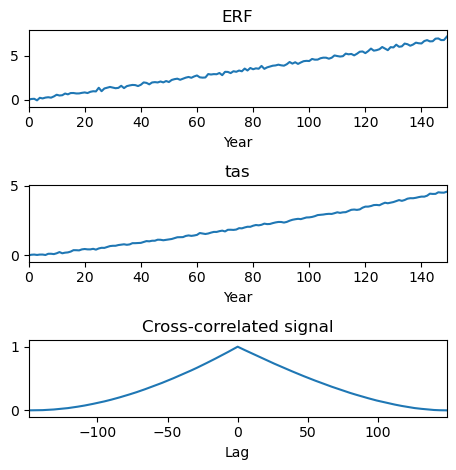

In [4]:
fig, (ax_orig, ax_noise, ax_corr) = plt.subplots(3, 1, figsize=(4.8, 4.8))
ax_orig.plot(ERF)
ax_orig.set_title('ERF')
ax_orig.set_xlabel('Year')
ax_noise.plot(tas_glob)
ax_noise.set_title('tas')
ax_noise.set_xlabel('Year')
ax_corr.plot(lags, corr)
ax_corr.set_title('Cross-correlated signal')
ax_corr.set_xlabel('Lag')
ax_orig.margins(0, 0.1)
ax_noise.margins(0, 0.1)
ax_corr.margins(0, 0.1)
fig.tight_layout()
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
output_path = ERFutils.path_to_ERF_outputs
train = '1pctCO2'
A = ERFutils.A

tas_path = f'{output_path}tas/tas_CMIP_{train}_all_ds.nc4'
tas_ds = (xr.open_dataset(tas_path)).mean(dim = 'model')
tas_glob_ds = (tas_ds.weighted(A).mean(dim = ['lat','lon'])).rename({'s': 'year'})

reg = LinearRegression().fit(tas_glob_ds.year.values[20:140].reshape(-1,1),tas_glob_ds.tas.values[20:140].reshape(-1,1))
reg.coef_

In [ ]:
import matplotlib.pyplot as plt

plt.plot(tas_glob_ds.tas.values[20:140])
plt.plot(tas_glob_ds.year.values[20:140]*reg.coef_[0] + reg.intercept_)
variability = np.std(tas_glob_ds.tas.values[20:140] - tas_glob_ds.year.values[20:140]*reg.coef_[0] + reg.intercept_)
variability

In [31]:
import scipy.optimize as opt
from scipy.sparse.linalg import spsolve_triangular

train = '1pctCO2'
output_path = ERFutils.path_to_ERF_outputs
A = ERFutils.A

ERF_path = f'{output_path}ERF/ERF_{train}_all_ds.nc4'
ERF_ds = xr.open_dataset(ERF_path)
ERF_ds = ERFutils.concat_multirun(ERFutils.ds_to_dict(ERF_ds),'model').mean(dim = 'model')

ERF = ERF_ds.ERF
ERF_ds.close()

n = len(ERF_ds['year'])

tas_path = f'{output_path}tas/tas_CMIP_{train}_all_ds.nc4'
tas_ds = (xr.open_dataset(tas_path)).mean(dim = 'model')
tas_glob_ds = (tas_ds.weighted(A).mean(dim = ['lat','lon'])).rename({'s': 'year'})
tas_glob_ds = tas_glob_ds.sel(year = slice(ERF_ds['year'].min(), ERF_ds['year'].max()))

tas_glob = tas_glob_ds.tas
tas_ds.close()

G_ds_path = f'{output_path}GFs/G_loess_man_{train}_ERF_mean_ds.nc4'
G_ds = xr.open_dataset(G_ds_path)['G[tas]']
        
G_ds.name = 'G[tas]'
G_ds = G_ds.rename({'year':'s'})

G0 = G_ds.weighted(A).mean(dim = ['lat','lon']).values
G0 = np.pad(G0,(0,n - len(G0)),mode='reflect')
G_ds.close()

offsets = [i for i in range(0,-n,-1)]
#A = diags(ERF,offsets=offsets,shape=(n,n),format='csr')
#b = tas_glob

#plt.plot(np.dot(LA.pinv((A + 20*identity(n)).toarray()),b))

In [95]:
years = tas_glob_ds.year.values
F_mat = diags(ERF,offsets=offsets,shape=(n,n),format='csr')

def get_opt_G(tas,inits):
    bnds = [(1,6),(0,None),(tau_2_factor,6*tau_2_factor),(0,None),(80,1000),(0,None)]
    n_modes = 3

    min_test = opt.minimize(objective_exp, inits[0:2*n_modes], args=tas, bounds=bnds[0:2*n_modes])
    return calc_G(min_test.x,n_modes), min_test.x

def objective_exp(x,tas):
      
    G_sum = np.zeros(n)
    for k in range(n_modes):
        e = np.exp(np.divide(-years,x[2*k]))
        E = diags(e,shape=(n,n),format='csr')
        c = x[2*k + 1]*np.ones(n)
        G_sum += np.dot(F_mat, E)*c
        
    error = tas - G_sum
    
    return np.dot(error,error)

def calc_G(x,n_modes):
    G_sum = np.zeros(n)
    for k in range(n_modes):
        e = np.exp(np.divide(-years,x[2*k]))
        E = diags(e,shape=(n,n),format='csr')
        c = x[2*k + 1]*np.ones(n)
        G_sum += E*c
    
    return G_sum

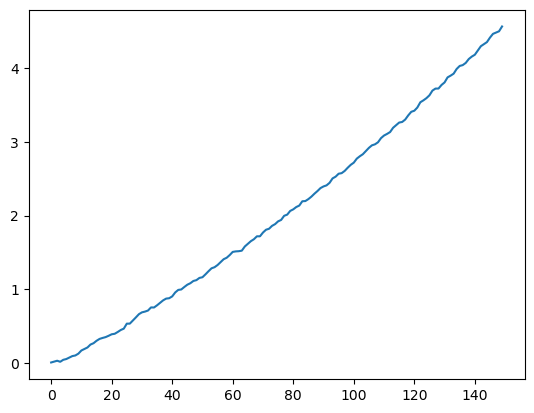

In [81]:
x = [11.9782232,0.05638466]
x2 = [4.65579578e+00,1.01174715e-01,1.30486657e+02,2.83467502e-03]
x3 = [3.46592871e+00,1.12606672e-01,5.03685584e+01,6.24011055e-03,8.97981397e+02,1.00000000e+01]
#plt.plot(tas_glob)
plt.plot(F_mat*calc_G(min_test.x,n_modes))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


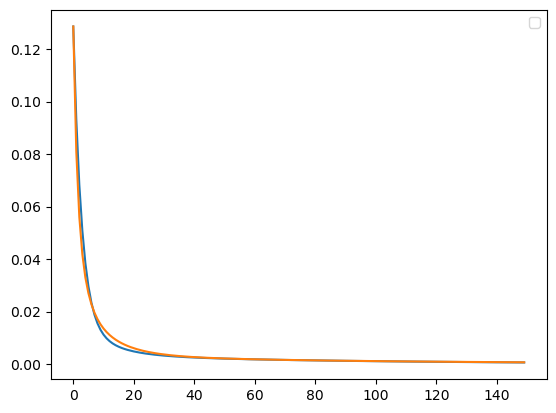

In [97]:
import random

train = '1pctCO2'
output_path = ERFutils.path_to_ERF_outputs
A = ERFutils.A

ERF_path = f'{output_path}ERF/ERF_{train}_all_ds.nc4'
ERF_ds = xr.open_dataset(ERF_path)
ERF_ds = ERFutils.concat_multirun(ERFutils.ds_to_dict(ERF_ds),'model').mean(dim = 'model')

ERF = ERF_ds.ERF
ERF_ds.close()

n = len(ERF_ds['year'])

tas_path = f'{output_path}tas/tas_CMIP_{train}_all_ds.nc4'
tas_ds = (xr.open_dataset(tas_path)).mean(dim = 'model')
tas_ds = tas_ds.sel(s = slice(ERF_ds['year'].min(), ERF_ds['year'].max()))
tas_glob_ds = (tas_ds.weighted(A).mean(dim = ['lat','lon'])).rename({'s': 'year'})

tas_glob = tas_glob_ds.tas
years = tas_glob_ds.year.values
tas_ds.close()

F_mat = diags(ERF,offsets=offsets,shape=(n,n),format='csr')

tau_1_0 = np.random.uniform(low=1, high=6)
tau_2_factor = np.random.uniform(low=5, high=10)
tau_2_0 = tau_1_0*tau_2_factor
tau_3_0 = np.random.uniform(low=80, high=1000)
c_1_0 = 10
c_2_0 = 10
c_3_0 = 10

inits = [tau_1_0,c_1_0,tau_2_0,c_2_0,tau_3_0,c_3_0]

G_glob, inits = get_opt_G(tas_glob, inits)

# Have to create the Green's functions locally, stack data array
stacked_response = tas_ds.stack(allpoints=['lat','lon'])
N_latlong = len(stacked_response.tas.values[0])
stacked_tas = stacked_response.tas.values

# Convert to np arrays, xarray indexing is too slow
G_stacked = np.zeros((n,N_latlong))

# Calculate local Green's functions, matrix is LD by construction
for k in range(100): 
    loc = random.randint(0,N_latlong)
    G_stacked[:,loc] = get_opt_G(stacked_tas[:,loc], inits)[0]

# Get G into the correct format
G = xr.Dataset(coords={'lon': ('lon', tas_ds.lon.values),
                        'lat': ('lat', tas_ds.lat.values),
                        'year': ('year', range(n))})
G = G.stack(allpoints=['lat','lon'])
G['G[tas]'] = (('year','allpoints'),G_stacked)
G = G.unstack('allpoints')

G['year'] = G['year'] - G['year'][0]

G_glob2 = G.weighted(A).mean(dim = ['lat','lon'])['G[tas]']  
plt.plot(G_glob)
plt.plot(G_glob2/G_glob2[0]*G_glob[0])

plt.legend()

In [ ]:
# Have to create the Green's functions locally, stack data array
stacked_response = tas_all.stack(allpoints=['lat','lon'])
N_latlong = len(stacked_response.tas.values[0])
stacked_tas = stacked_response.tas.values

# Convert to np arrays, xarray indexing is too slow
G_stacked = np.zeros((N_years,N_latlong))

# Calculate local Green's functions, matrix is LD by construction
for n in range(N_latlong):
    if n % 5000 == 0:
        print(n)
    Y3 = stacked_tas[:,n] - stacked_tas[m,n]
    stacked_response_local = [local_weighted_regression(x0, X2, Y3, tau) for x0 in domain]
    G_stacked[:,n] = spsolve_triangular(input_matrix,stacked_response_local,lower=True)

# Get G into the correct format
G = xr.Dataset(coords={'lon': ('lon', tas_all.lon.values),
                        'lat': ('lat', tas_all.lat.values),
                        'year': ('year', range(N_years))})
G = G.stack(allpoints=['lat','lon'])
G['G[tas]'] = (('year','allpoints'),G_stacked)
G = G.unstack('allpoints')

G['year'] = G['year'] - G['year'][0]

G.to_netcdf(f'{output_path}GFs/G_loess_h_z_{train}_ERF_mean_ds.nc4')